In [23]:
%matplotlib inline

from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap

import warnings
warnings.filterwarnings('ignore')

In [24]:
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["figure.figsize"] = (28, 16)

mpl.rcParams["font.family"] = "DejaVu Sans"

In [25]:
MAIN_FOLDER = Path().resolve()
DATA_FOLDER = MAIN_FOLDER / "data"
TRIPS_FOLDER = DATA_FOLDER / "Concat_trips_2013-2019"

## 1. Исследование данных на качество (погодные условия)

### Загрузка сырых данных

Данные были взяты с официального сайта города Чикаго по ссылке: [Beach Weather Stations - Automated Sensors](https://data.cityofchicago.org/Parks-Recreation/Beach-Weather-Stations-Automated-Sensors/k7hf-8y75/about_data).

Описание датасета:
| Поле API                     | Описание                                                                 |
|------------------------------|--------------------------------------------------------------------------|
| `station_name`               | Название метеостанции                                                   |
| `measurement_timestamp`      | Дата и время проведения измерений                                       |
| `air_temperature`            | Температура воздуха (°C)                                                |
| `wet_bulb_temperature`       | Температура по влажному термометру (°C)                                 |
| `humidity`                   | Относительная влажность (%)                                             |
| `rain_intensity`             | Интенсивность осадков (мм/час)                                          |
| `interval_rain`              | Осадки с последнего замера (мм)                                         |
| `total_rain`                 | Суммарные осадки с полуночи (мм)                                        |
| `precipitation_type`         | Тип осадков (0=нет, 60=дождь, 70=снег, 40=не определено)               |
| `wind_direction`             | Направление ветра (градусы)                                             |
| `wind_speed`                 | Скорость ветра (м/с или км/ч)                                           |
| `maximum_wind_speed`         | Максимальная скорость ветра за 2 минуты                                 |
| `barometric_pressure`        | Атмосферное давление (гПа)                                              |
| `solar_radiation`            | Солнечная радиация (Вт/м²)                                              |
| `heading`                    | Направление ветроизмерительного устройства (0° = север)                 |
| `battery_life`               | Напряжение батареи (индикатор заряда)                                   |
| `measurement_timestamp_label`| Метка времени в текстовом формате ("Последнее обновление")              |
| `measurement_id`             | Уникальный ID (станция + временная метка)                               |

*Название столбцов были приведены к PEP-8 формату изначально для удобства.*

In [26]:
weather = pd.read_csv(DATA_FOLDER / "beach_weather_stations_automated_sensors_20250409.csv", sep=",")
weather.columns = weather.columns.str.lower().str.replace(" ", "_")
weather.head()

,station_name,measurement_timestamp,air_temperature,wet_bulb_temperature,humidity,rain_intensity,interval_rain,total_rain,precipitation_type,wind_direction,wind_speed,maximum_wind_speed,barometric_pressure,solar_radiation,heading,battery_life,measurement_timestamp_label,measurement_id
0,63rd Street Weather Station,09/27/2018 10:00:00 AM,16.40,12.2,61,0.0,0.0,260.3,0.0,231,2.5,4.7,996.3,484,356.0,11.9,09/27/2018 10:00 AM,63rdStreetWeatherStation201809271000
1,63rd Street Weather Station,09/27/2018 11:00:00 AM,17.10,11.5,51,0.0,0.0,260.3,0.0,244,3.6,5.7,995.4,468,356.0,11.9,09/27/2018 11:00 AM,63rdStreetWeatherStation201809271100
2,63rd Street Weather Station,09/27/2018 01:00:00 PM,18.20,12.4,51,0.0,0.0,260.3,0.0,248,3.1,5.3,994.8,377,355.0,11.9,09/27/2018 1:00 PM,63rdStreetWeatherStation201809271300
3,Foster Weather Station,09/27/2018 01:00:00 PM,17.89,NaN,39,NaN,0.0,NaN,NaN,249,1.4,2.3,993.6,0,NaN,15.1,09/27/2018 1:00 PM,FosterWeatherStation201809271300
4,63rd Street Weather Station,09/27/2018 03:00:00 PM,19.50,13.0,47,0.0,0.0,260.3,0.0,249,3.1,5.7,992.9,461,355.0,11.9,09/27/2018 3:00 PM,63rdStreetWeatherStation201809271500


### 1.1 Убрать избыточные данные

Для упрощения модели и устранения избыточности были удалены следующие столбцы:

- **`wet_bulb_temperature`** — вычисляется на основе `air_temperature` и `humidity`, поэтому является производным признаком.
- **`interval_rain`** и **`total_rain`** — напрямую зависят от `rain_intensity`, что может вызвать коллинеарность. Кроме того, данные собираются с интервалом в 2–3 часа, чего достаточно для оценки погодных условий.
- **`wind_direction`** — направление ветра не оказывает существенного влияния на аренду велосипедов.
- **`maximum_wind_speed`** — дублирует информацию `wind_speed`.
- **`barometric_pressure`**, **`solar_radiation`**, **`heading`**, **`battery_life`**, **`measurement_timestamp_label`**, **`measurement_id`** — не представляют ценности для прогнозирования и могут быть удалены.

In [27]:
weather = weather[
    [
        "station_name",
        "measurement_timestamp",
        "air_temperature",
        "humidity",
        "rain_intensity",
        "precipitation_type",
        "wind_speed",
    ]
]
weather.head()

,station_name,measurement_timestamp,air_temperature,humidity,rain_intensity,precipitation_type,wind_speed
0,63rd Street Weather Station,09/27/2018 10:00:00 AM,16.40,61,0.0,0.0,2.5
1,63rd Street Weather Station,09/27/2018 11:00:00 AM,17.10,51,0.0,0.0,3.6
2,63rd Street Weather Station,09/27/2018 01:00:00 PM,18.20,51,0.0,0.0,3.1
3,Foster Weather Station,09/27/2018 01:00:00 PM,17.89,39,NaN,NaN,1.4
4,63rd Street Weather Station,09/27/2018 03:00:00 PM,19.50,47,0.0,0.0,3.1


### 1.2 Исследовать тип данных, привести данные к правильному типу, где это необходимо

In [28]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186307 entries, 0 to 186306
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   station_name           186307 non-null  object 
 1   measurement_timestamp  186307 non-null  object 
 2   air_temperature        186232 non-null  float64
 3   humidity               186307 non-null  int64  
 4   rain_intensity         115859 non-null  float64
 5   precipitation_type     115859 non-null  float64
 6   wind_speed             186307 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 9.9+ MB


Изменим тип столбца `measurement_timestamp` на datetime

In [29]:
weather["measurement_timestamp"] = pd.to_datetime(weather["measurement_timestamp"])
weather["measurement_timestamp"].head()

0   2018-09-27 10:00:00
1   2018-09-27 11:00:00
2   2018-09-27 13:00:00
3   2018-09-27 13:00:00
4   2018-09-27 15:00:00
Name: measurement_timestamp, dtype: datetime64[ns]

### 1.3 Обработка аномальных значений (абсурдных или физический невозможных)

До удаление аномальных значений посмотрим как у нас обстоят дела с пропусками и непокрытыми днями.

In [30]:
def check_daily_coverage(
    df: pd.DataFrame,
    timestamp_col: str = "measurement_timestamp",
    interval_hours: int = 3,
) -> None:
    df = df.copy()
    df["date"] = df[timestamp_col].dt.date
    df["hour"] = df[timestamp_col].dt.hour
    df["interval"] = (df["hour"] // interval_hours) * interval_hours

    total_intervals = 24 // interval_hours

    intervals = df.groupby(["date", "interval"]).size().reset_index(name="count")
    intervals_per_day = intervals.groupby("date").size().reset_index(name="intervals_covered")
    intervals_per_day["fully_covered"] = intervals_per_day["intervals_covered"] == total_intervals

    all_dates = pd.date_range(df[timestamp_col].min().date(), df[timestamp_col].max().date(), freq="D").date
    missing_dates = set(all_dates) - set(df["date"].unique())

    partial_days = intervals_per_day[~intervals_per_day["fully_covered"]]["date"]
    partial_data = df[df["date"].isin(partial_days)]

    coverage_ratio = intervals_per_day["fully_covered"].mean()

    print(f"Отчет о покрытии (интервалы {interval_hours} часов):")
    print(f"- Полностью покрытые дни: {coverage_ratio:.1%}")
    print(f"- Дни с отсутствующими интервалами: {len(partial_days)}")
    print(f"- Даты без данных: {len(missing_dates)}")
    print(
        f"- Среднее количество интервалов/день: {intervals_per_day['intervals_covered'].mean():.1f}/{total_intervals}"
    )


check_daily_coverage(weather)

Отчет о покрытии (интервалы 3 часов):
- Полностью покрытые дни: 96.3%
- Дни с отсутствующими интервалами: 122
- Даты без данных: 382
- Среднее количество интервалов/день: 7.9/8


Мы сравним этот показатель после удаления.

Посмотрим на категориальный признак `station_name` на наличие несуществующих или неправильно напечатанных названий существующих.

In [31]:
weather["station_name"].unique()

array(['63rd Street Weather Station', 'Foster Weather Station',
       'Oak Street Weather Station'], dtype=object)

Не было обнаружено опечаток. Насчет наличие несуществующих, забегая вперед, могу сказать, что они существуют в реальности. Более подробно про станции написано в пункте .. 

Теперь проверим числовые признаки.

**air_temperature**

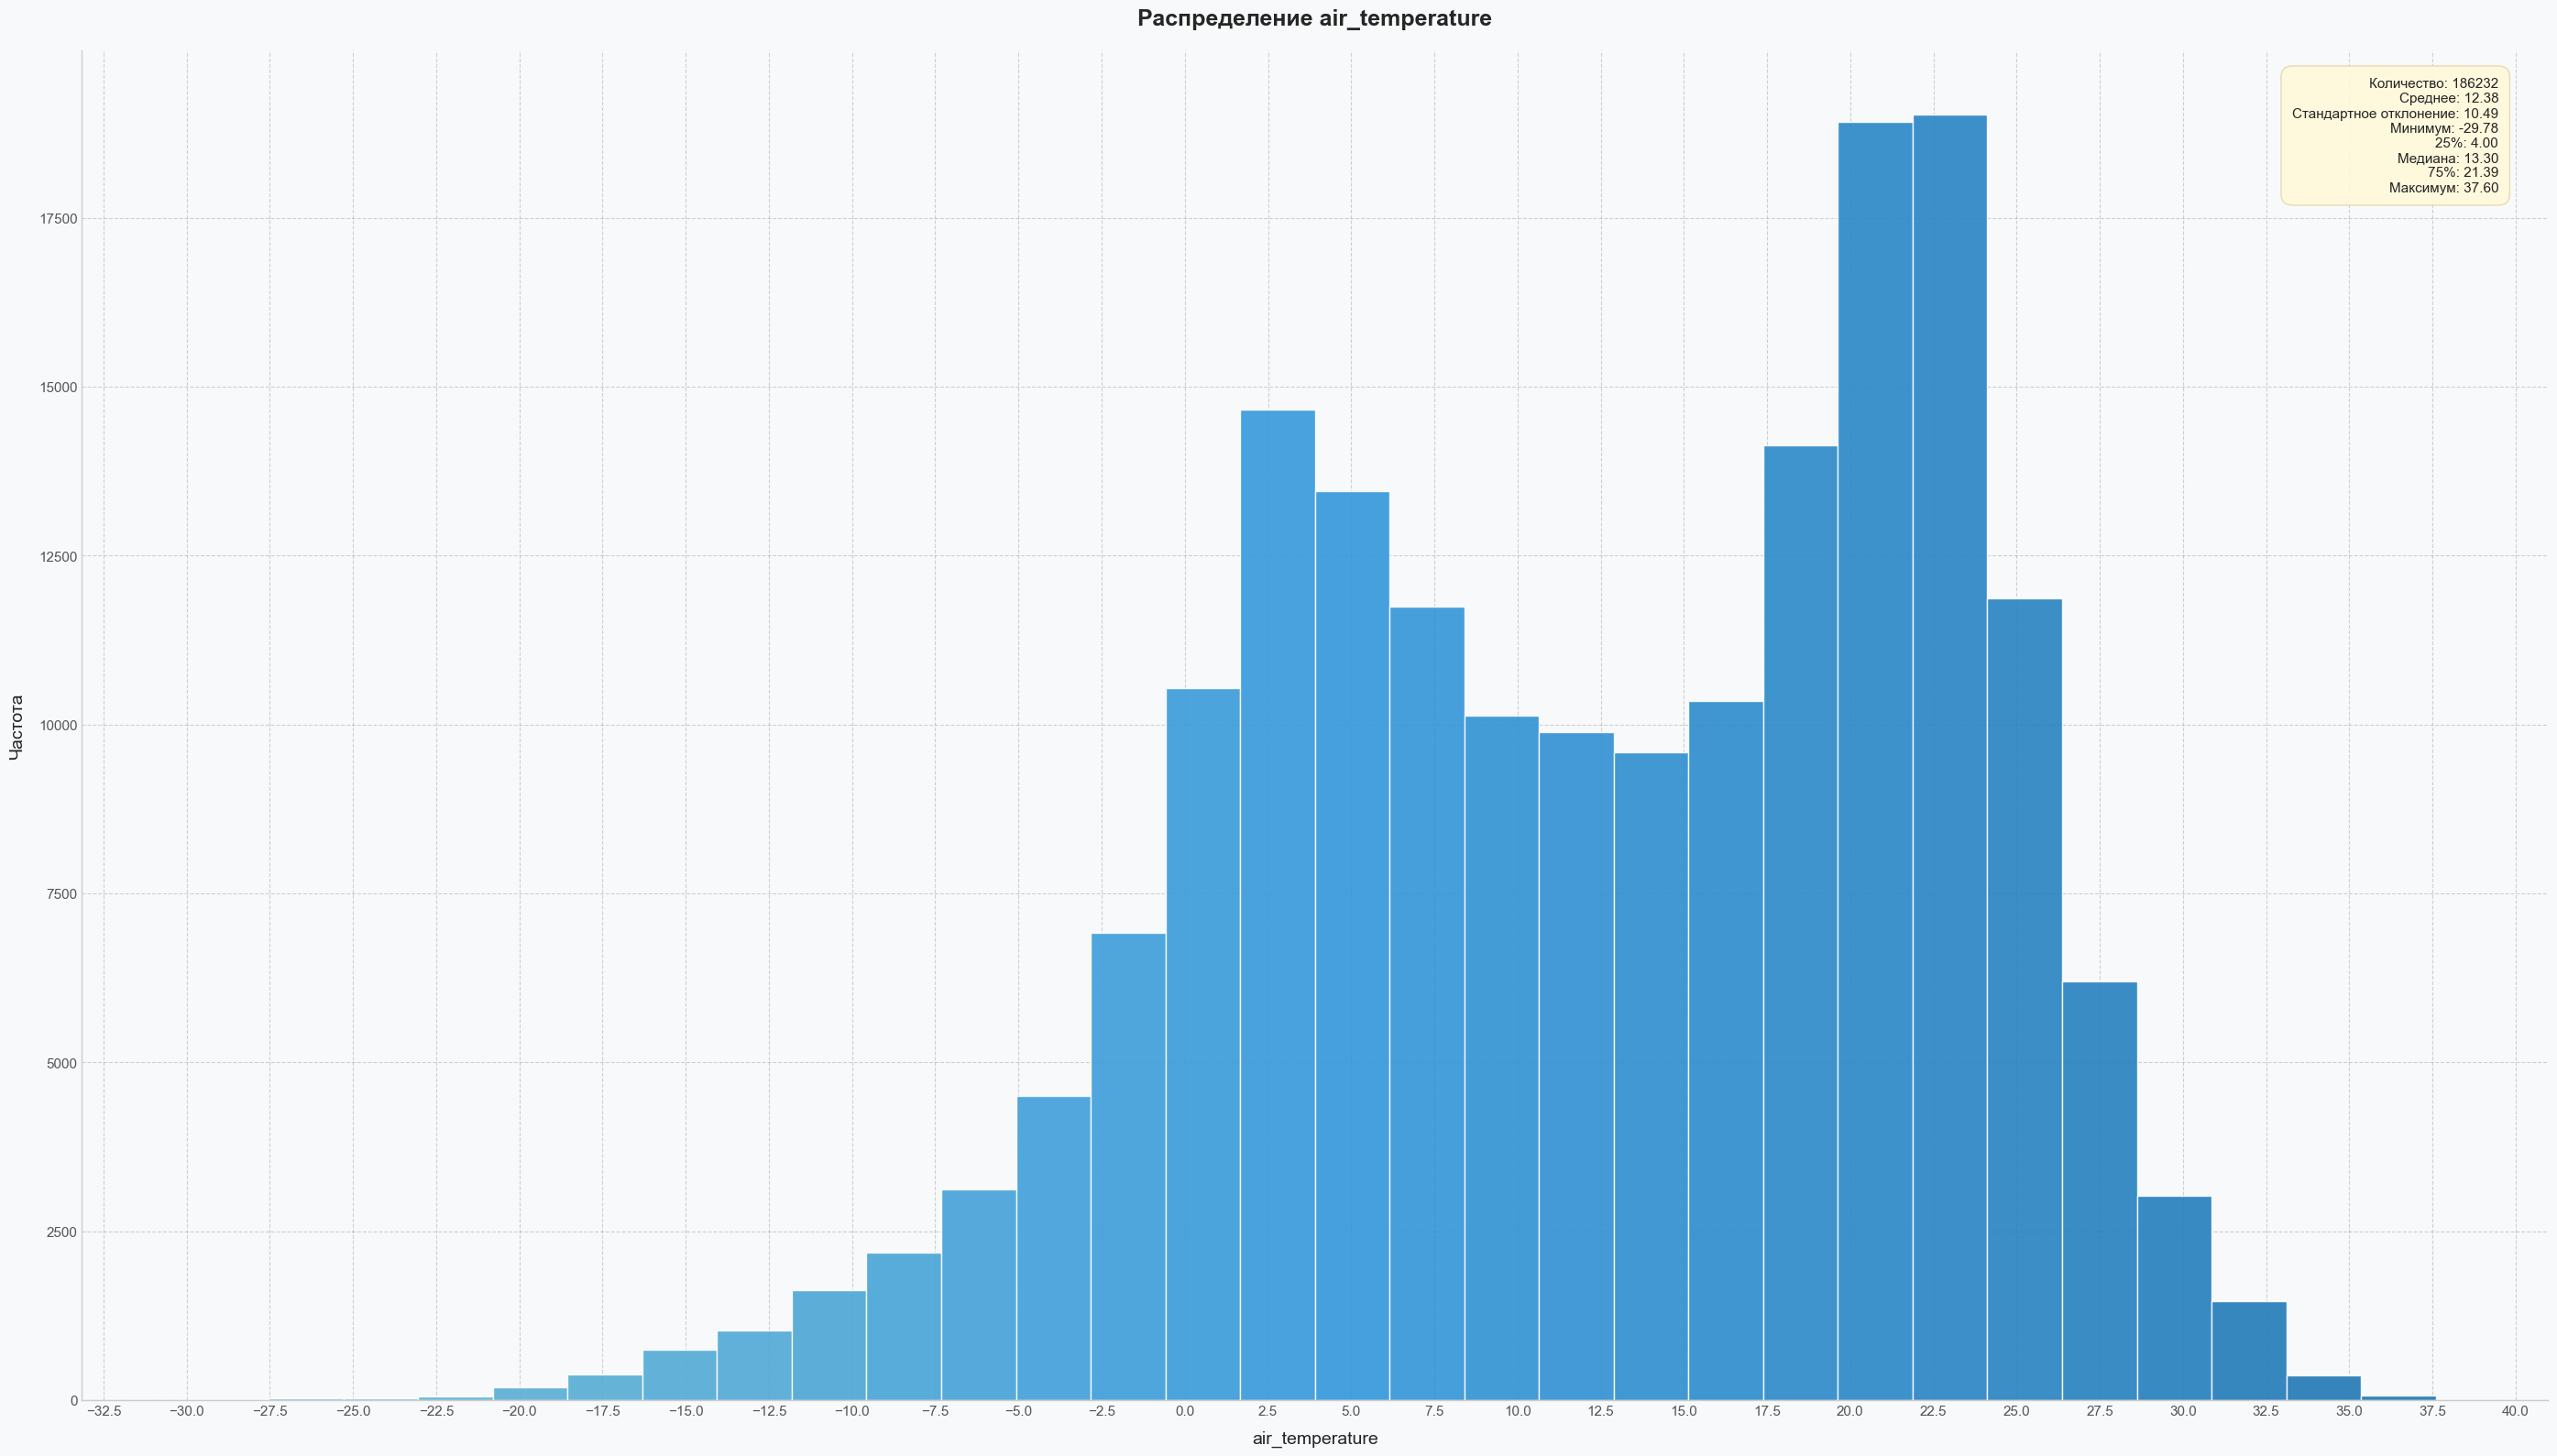

In [32]:
def plot_weather_histogram(data, column, log_scale=False, bins=30):
    if column not in data.columns:
        raise ValueError(f"Столбец '{column}' не найден в наборе данных.")

    stats = data[column].describe()
    colors = ["#67B7D1", "#3498db", "#1F77B4"]
    cmap = LinearSegmentedColormap.from_list("custom_blues", colors)

    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(facecolor="#F8F9FA")
    ax.set_facecolor("#F8F9FA")

    values = data[column].dropna()
    n, bins, patches = ax.hist(values, bins=bins, edgecolor="white", linewidth=1, alpha=0.9)

    centers = 0.5 * (bins[:-1] + bins[1:])
    norm_centers = (centers - centers.min()) / (centers.max() - centers.min())
    for c, p in zip(norm_centers, patches):
        plt.setp(p, "facecolor", cmap(c))

    if log_scale:
        ax.set_yscale("log")
        ax.yaxis.set_minor_locator(ticker.LogLocator(base=10, subs=np.arange(2, 10) * 0.1, numticks=10))
        ax.yaxis.set_minor_formatter(ticker.NullFormatter())

    ax.set_title(f"Распределение {column}", fontsize=18, pad=20, fontweight="bold")
    ax.set_xlabel(column, fontsize=14, labelpad=10)
    ylabel = "Частота (логарифмическая шкала)" if log_scale else "Частота"
    ax.set_ylabel(ylabel, fontsize=14, labelpad=10)

    stats_text = (
        f"Количество: {stats['count']:.0f}\n"
        f"Среднее: {stats['mean']:.2f}\n"
        f"Стандартное отклонение: {stats['std']:.2f}\n"
        f"Минимум: {stats['min']:.2f}\n"
        f"25%: {stats['25%']:.2f}\n"
        f"Медиана: {stats['50%']:.2f}\n"
        f"75%: {stats['75%']:.2f}\n"
        f"Максимум: {stats['max']:.2f}"
    )
    box_props = dict(boxstyle="round,pad=0.8", facecolor="#FFF8DC", edgecolor="#E6D9AB", alpha=0.95)

    ax.text(
        0.98,
        0.98,
        stats_text,
        transform=ax.transAxes,
        fontsize=11,
        va="top",
        ha="right",
        bbox=box_props,
        fontweight="medium",
    )

    ax.grid(True, alpha=0.3, linestyle="--", color="#6C757D")
    for spine in ax.spines.values():
        spine.set_edgecolor("#CCCCCC")
    ax.tick_params(axis="both", labelsize=11, colors="#555555")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))

    plt.tight_layout()
    plt.show()
    # return fig, ax


plot_weather_histogram(weather, "air_temperature")

`air_temperature` находиться в норме

**humidity**

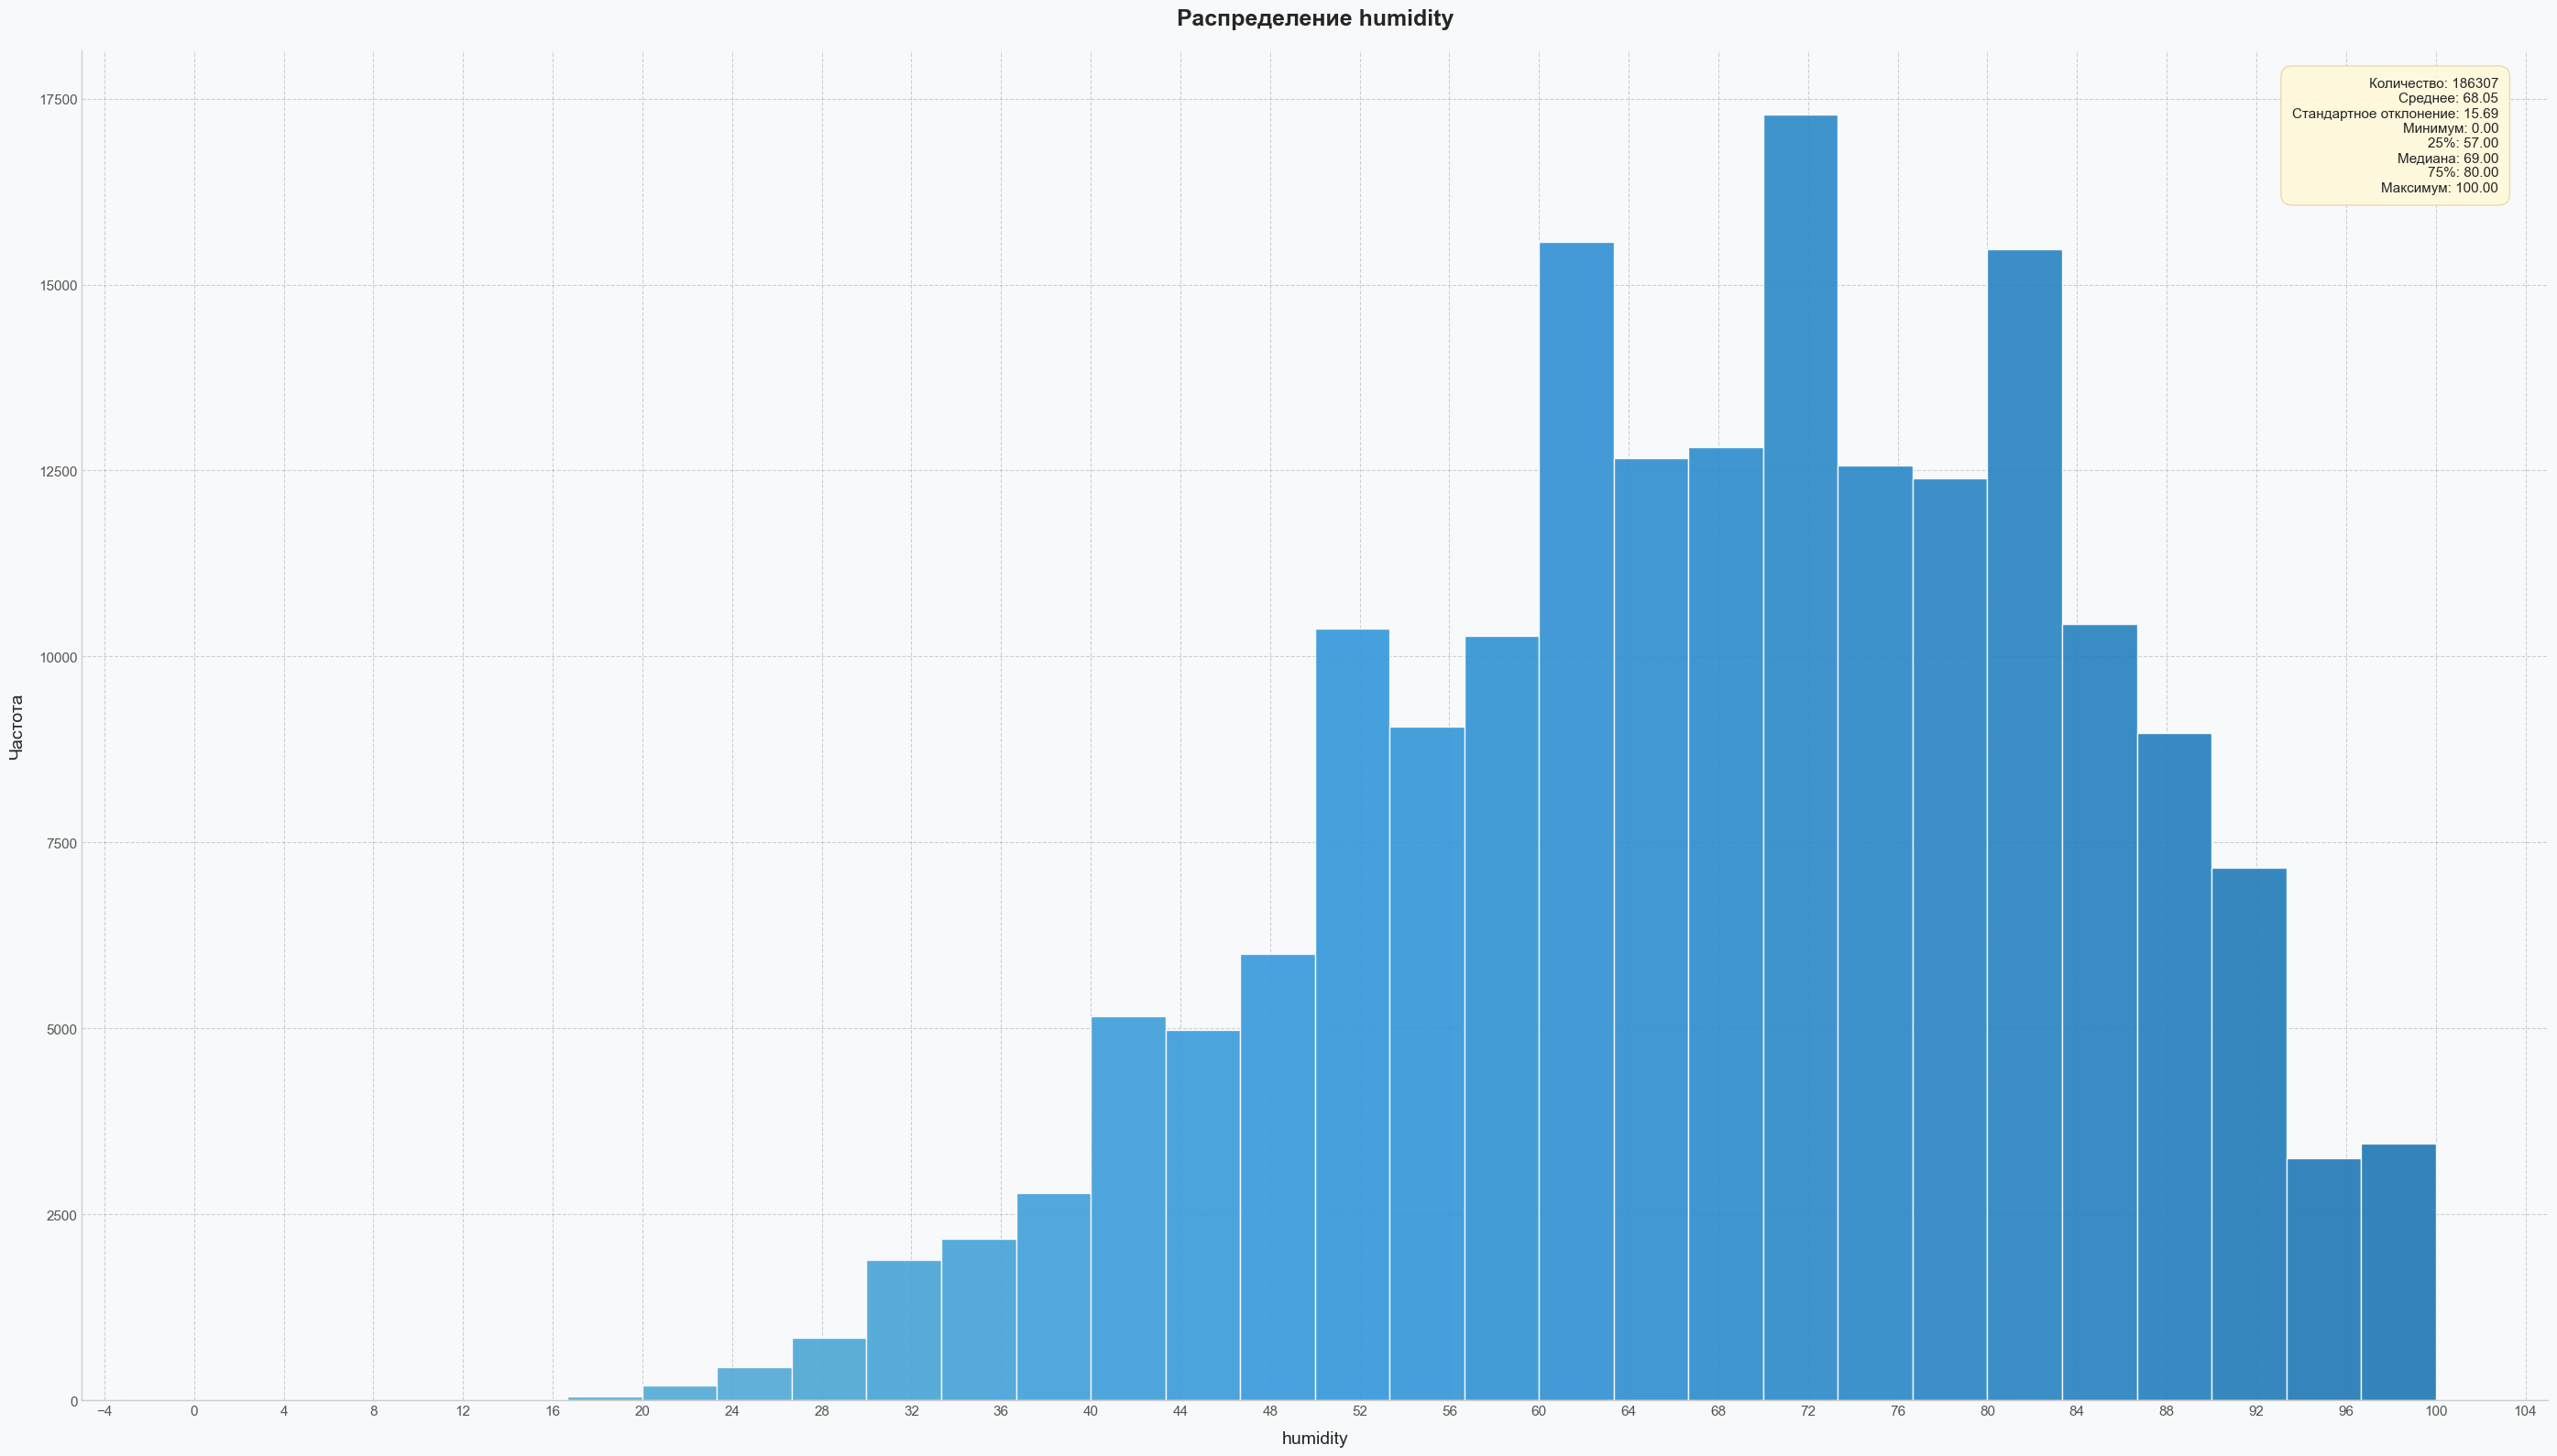

In [33]:
plot_weather_histogram(weather, "humidity")

**rain_intensity**

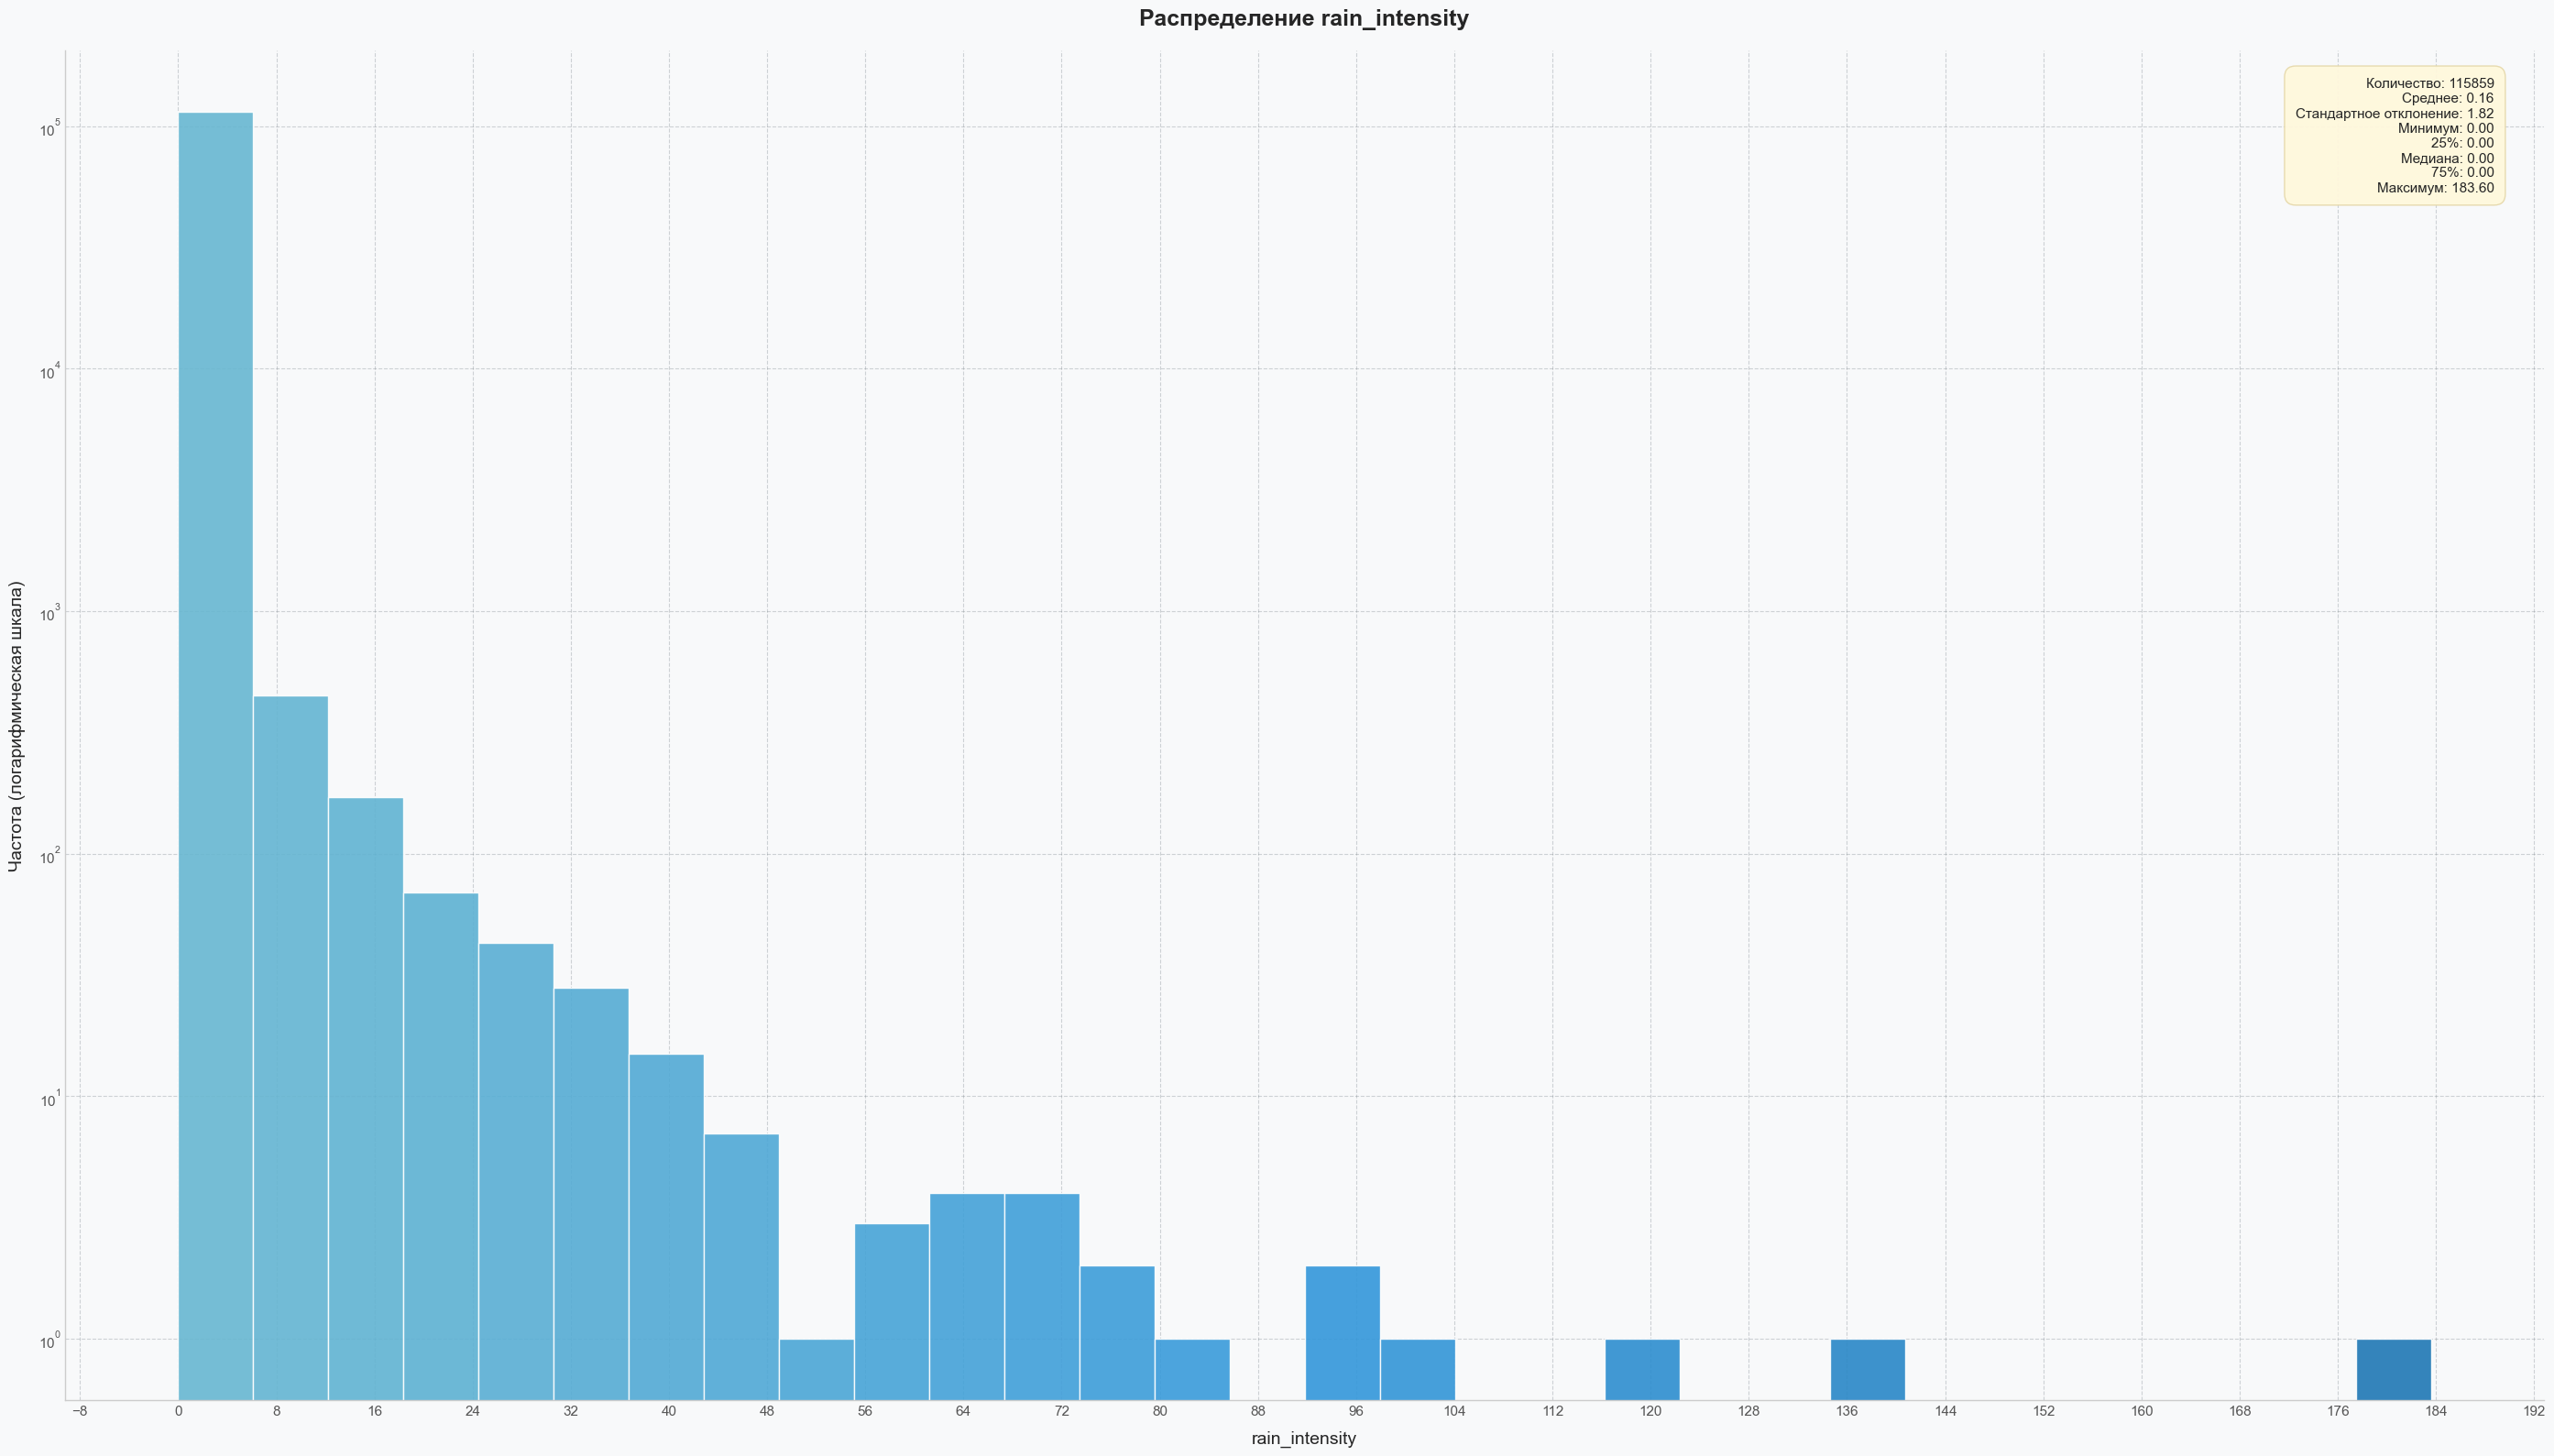

In [34]:
plot_weather_histogram(weather, "rain_intensity", log_scale=True)

| Тип дождя       | Интенсивность осадков (мм/ч)         |
|------------------|---------------------------------------|
| Лёгкий дождь     | Менее 2.5 мм/ч                        |
| Умеренный дождь  | От 2.6 до 7.5 мм/ч                    |
| Сильный дождь    | От 7.6 до 50 мм/ч                     |
| Ливень           | Более 50 мм/ч                         |

Удалим все, что более 50 мм/ч.

In [35]:
weather = weather[(weather["rain_intensity"] <= 50) | (weather["rain_intensity"].isna())]
weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186286 entries, 0 to 186306
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   station_name           186286 non-null  object        
 1   measurement_timestamp  186286 non-null  datetime64[ns]
 2   air_temperature        186211 non-null  float64       
 3   humidity               186286 non-null  int64         
 4   rain_intensity         115838 non-null  float64       
 5   precipitation_type     115838 non-null  float64       
 6   wind_speed             186286 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 11.4+ MB


**precipitation_type**

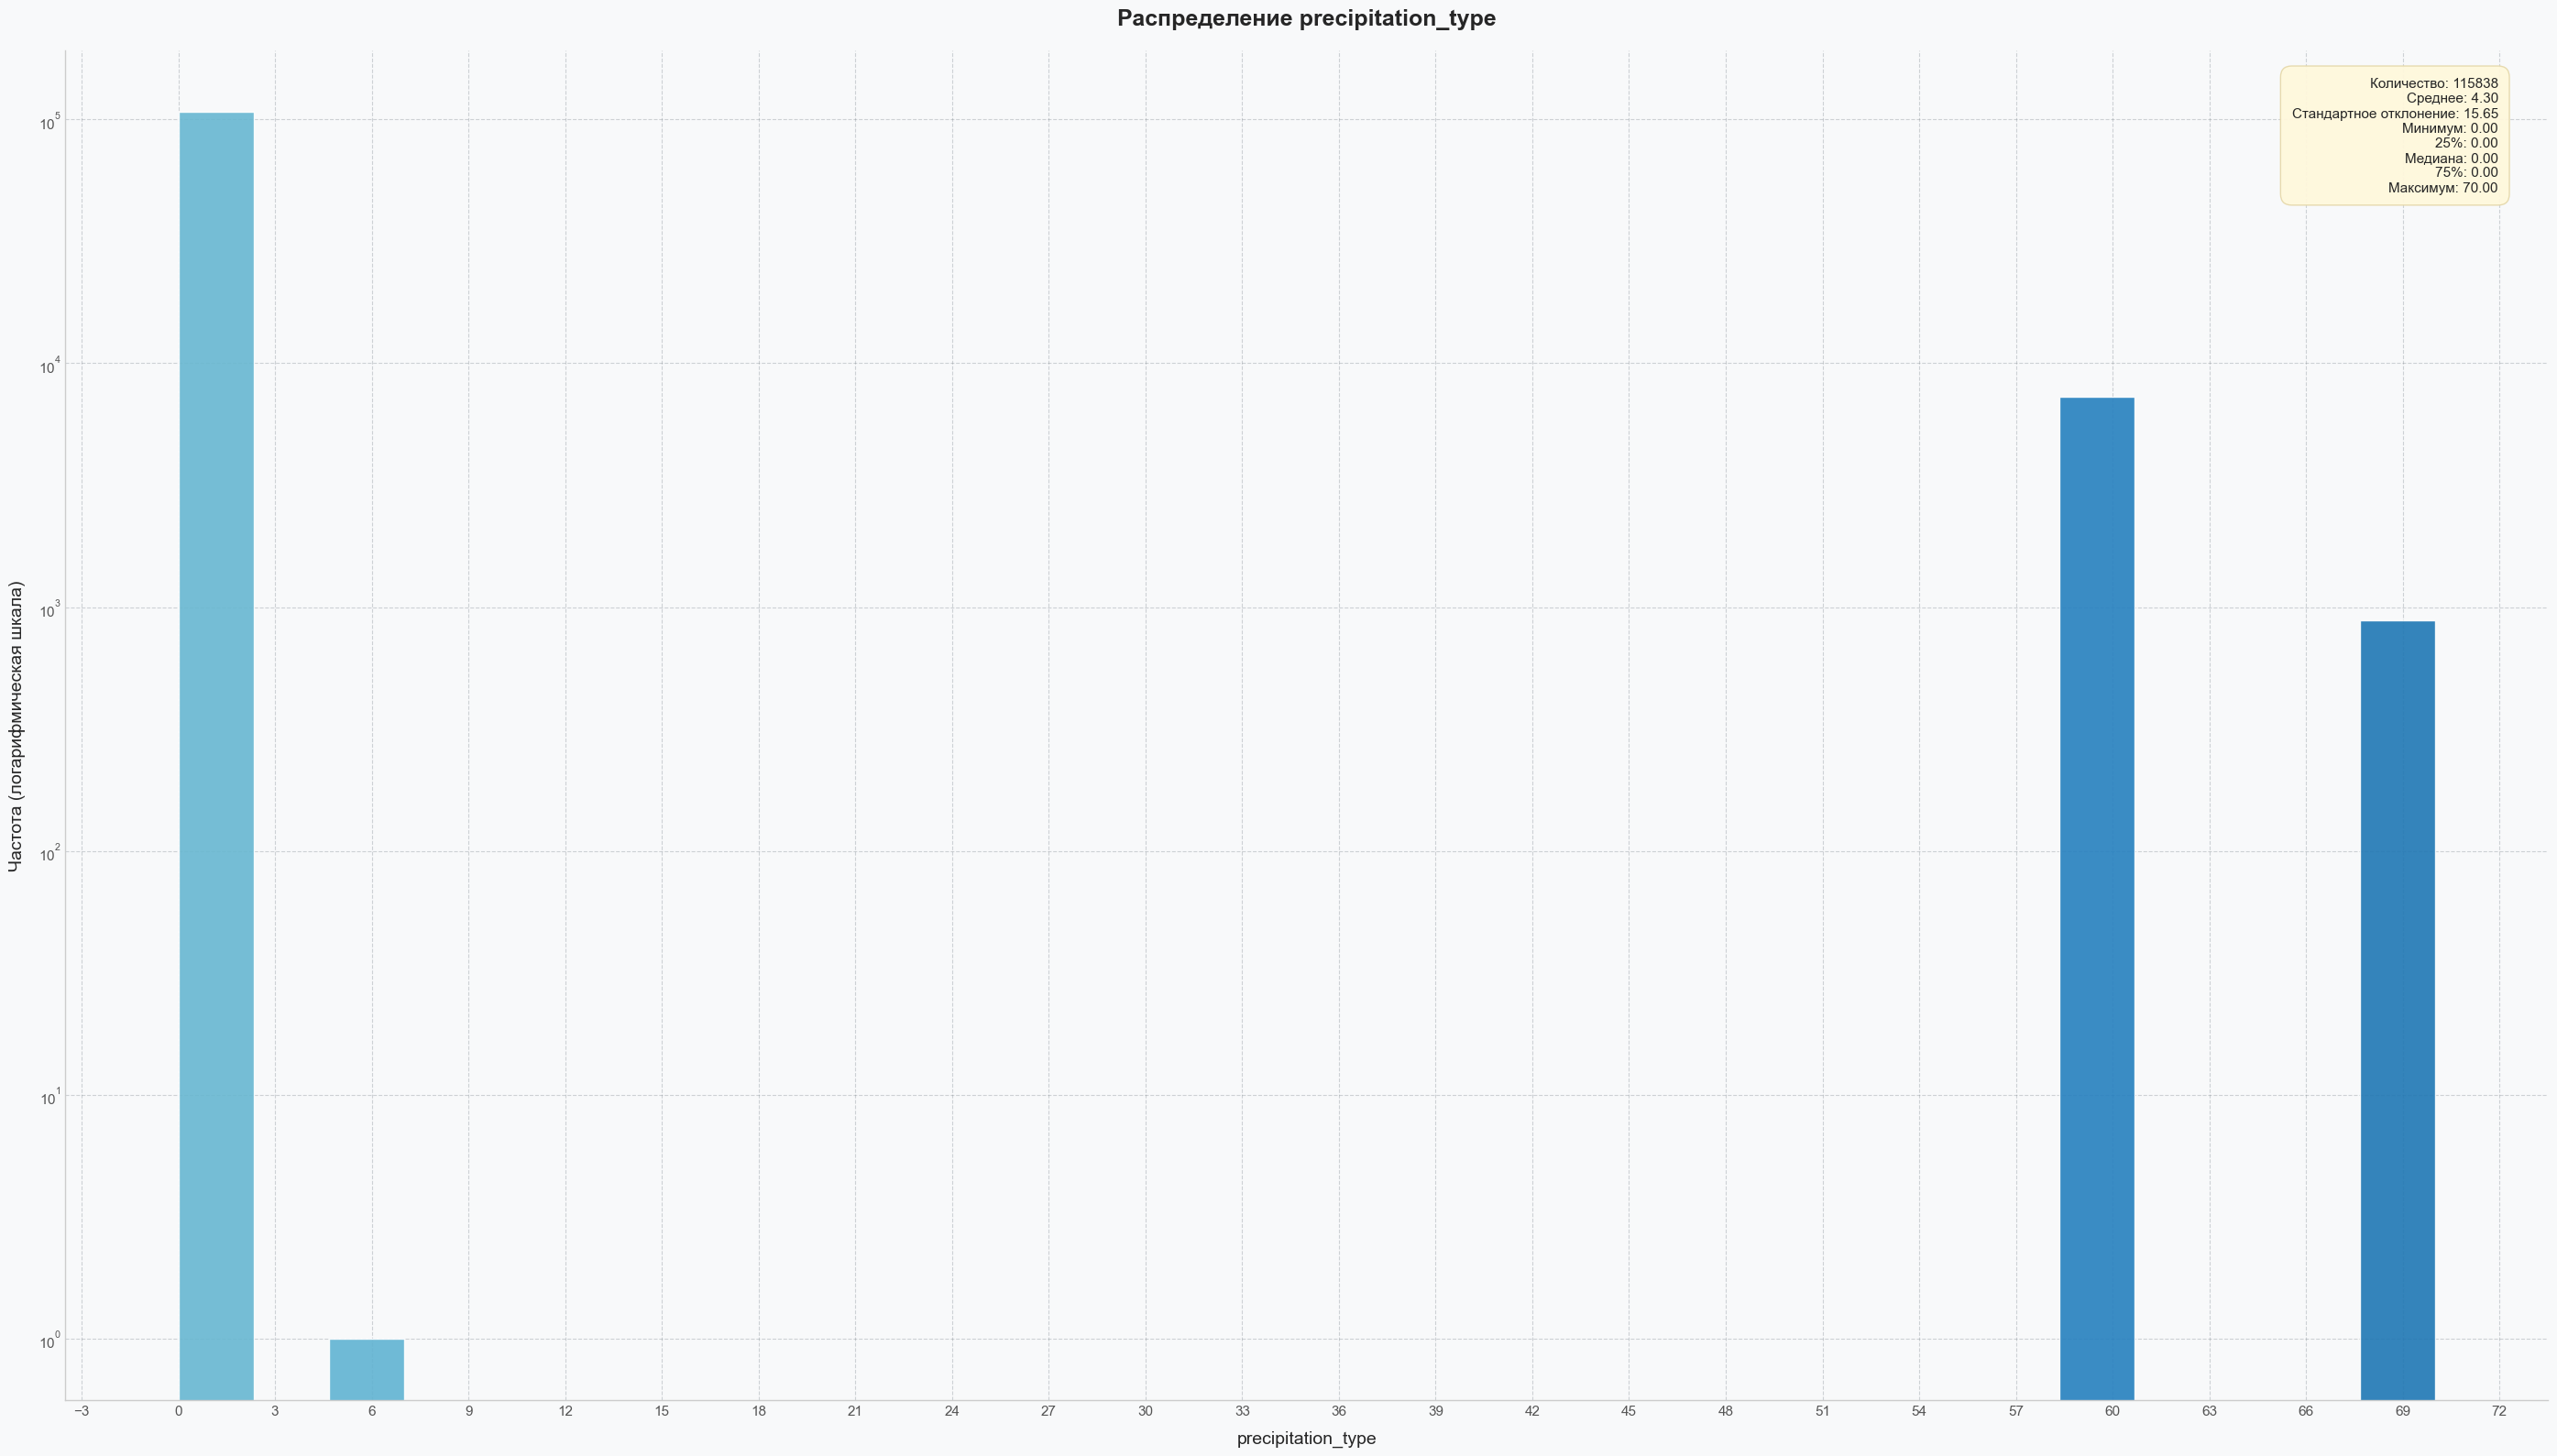

In [36]:
plot_weather_histogram(weather, "precipitation_type", log_scale=True)

Все в рамках датасета. Ничего не удаляем.

**wind_speed**

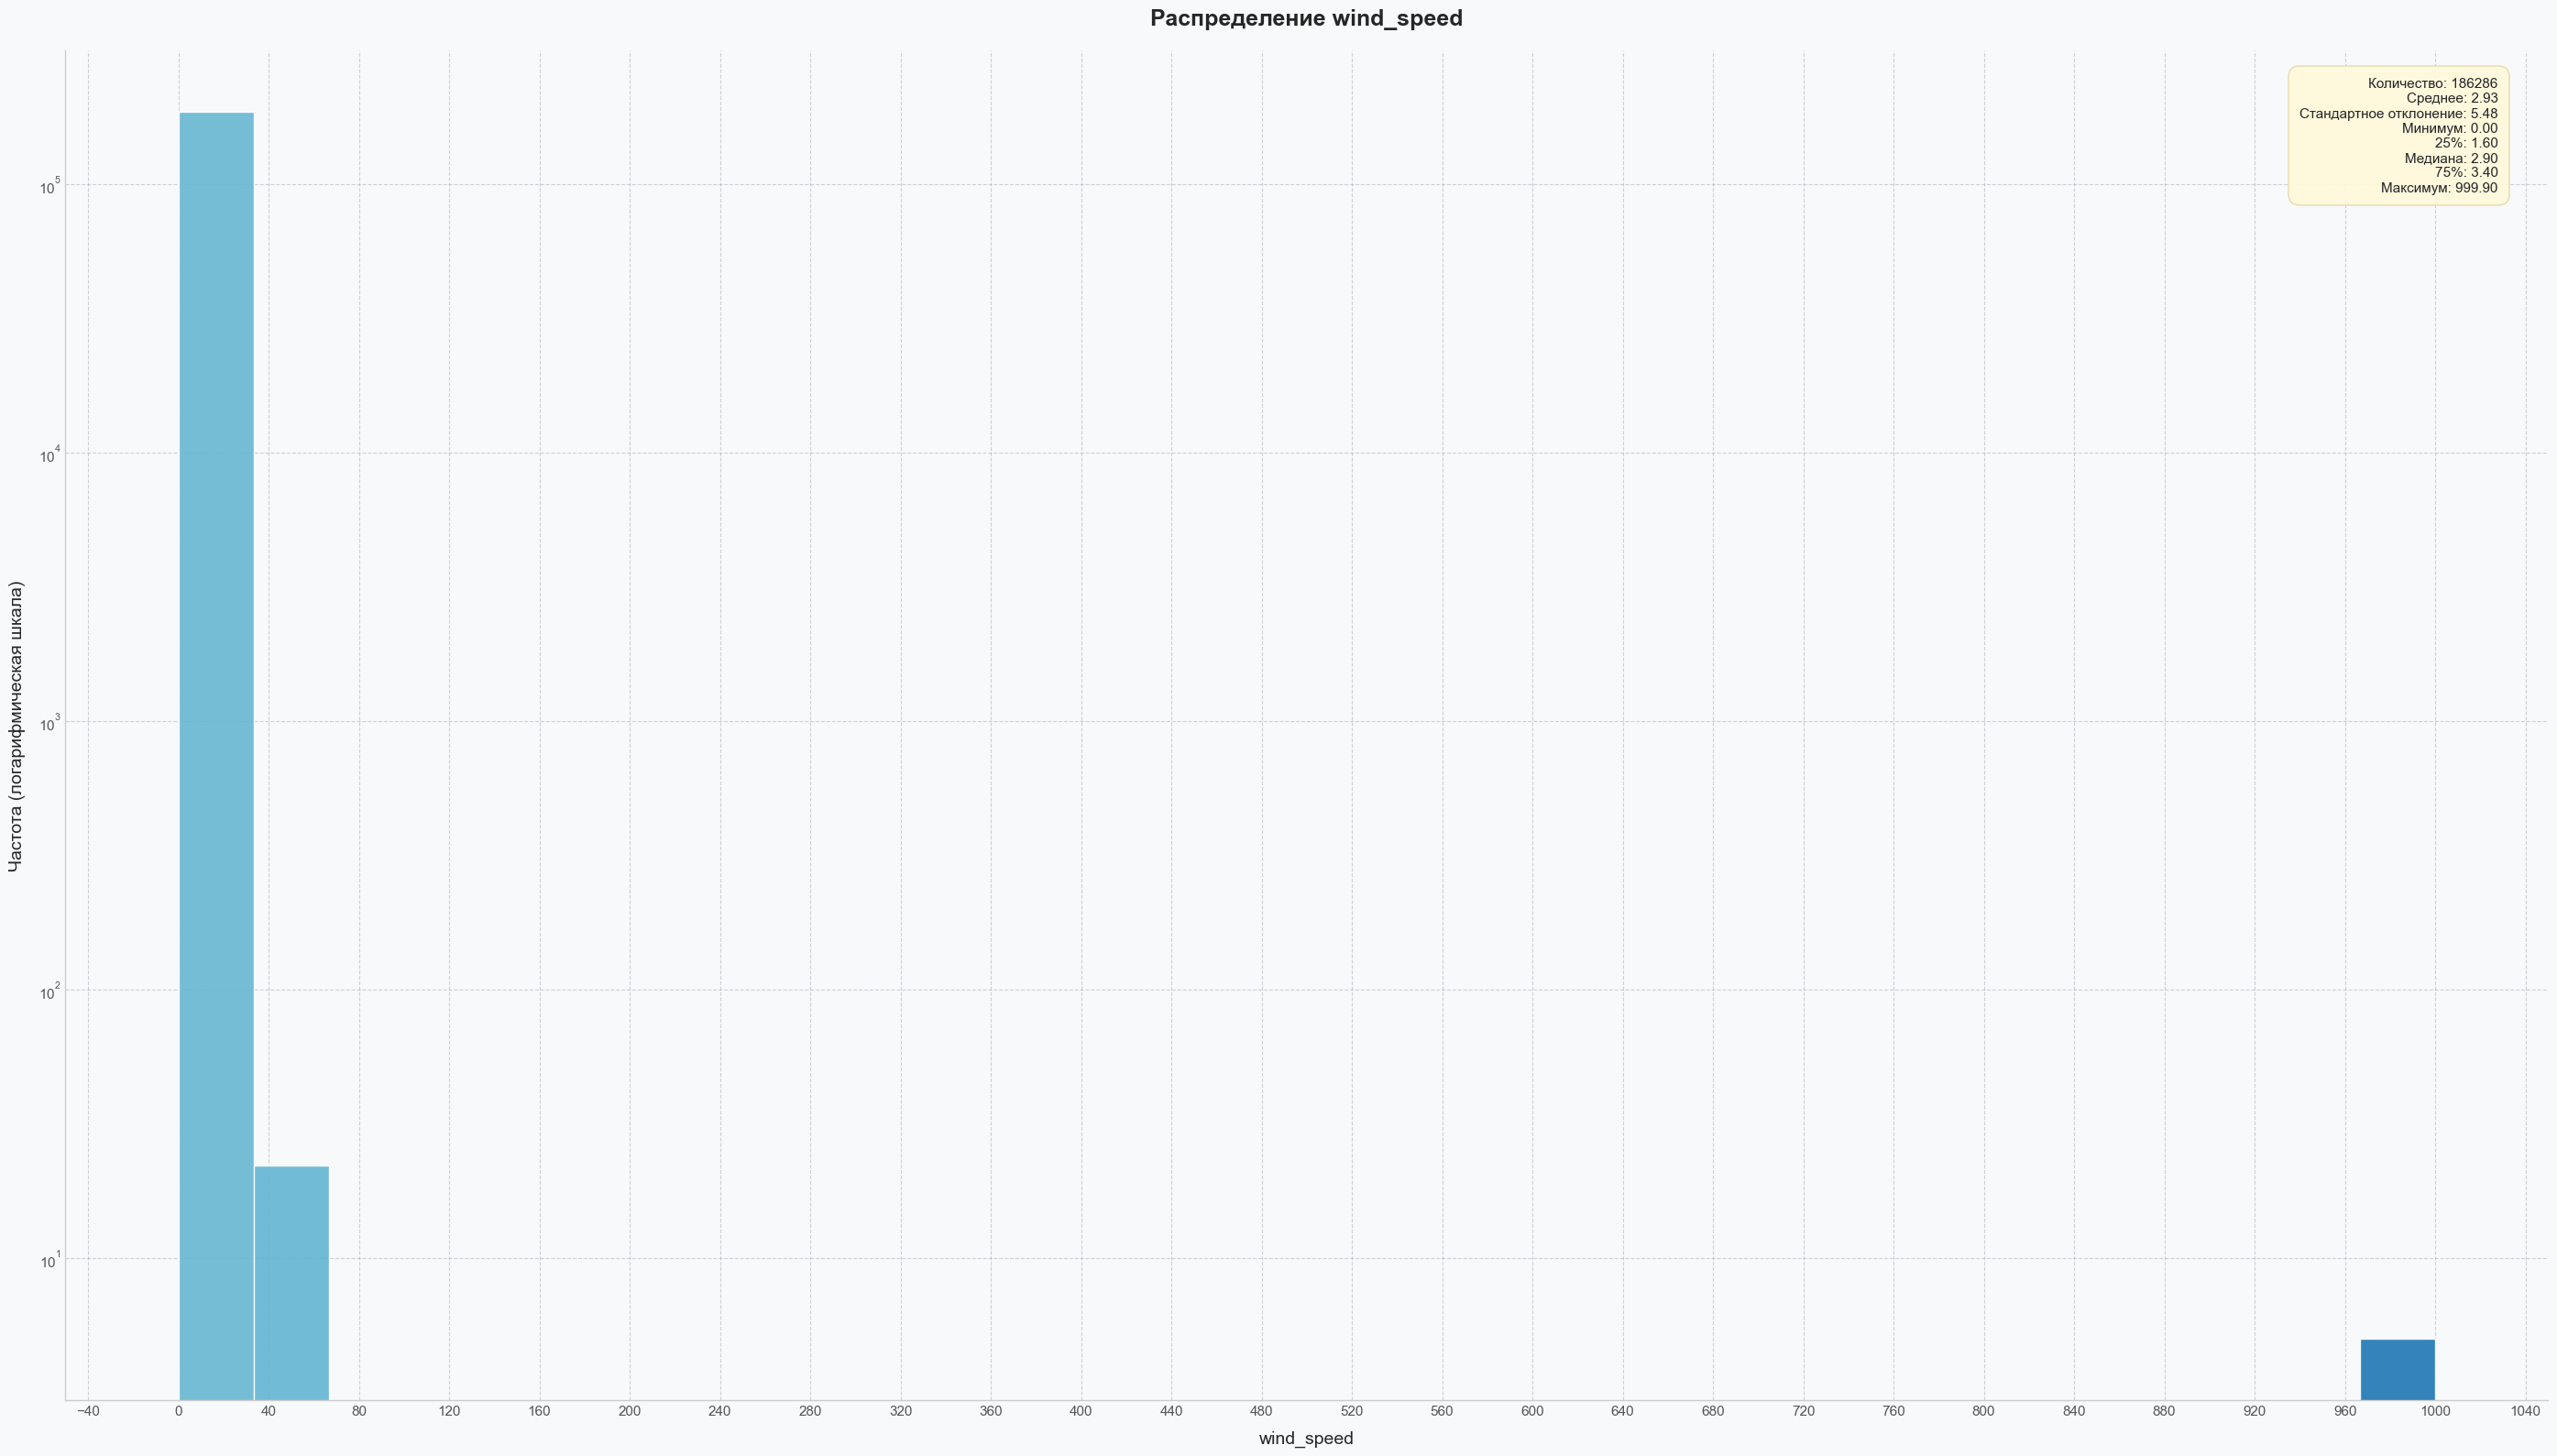

In [37]:
plot_weather_histogram(weather, "wind_speed", log_scale=True)

Все, что выше 11 м/с, является сильным порывом ветра. А если это значение превышает 900 м/c, то это ураган, что точно является аномальным значением. Удалим их и посмотрим на оставшиеся значения.

In [38]:
weather = weather[(weather["wind_speed"] <= 900) | (weather["wind_speed"].isna())]
plot_weather_histogram(weather, "wind_speed")

MemoryError: 

<Figure size 2800x1600 with 1 Axes>

Все находиться в пределах нормы.

https://www.researchgate.net/figure/These-are-the-standard-Beaufort-wind-speed-classifications-with-corresponding-wind-speed_tbl2_265538256

### 1.4 Обработать пропуски в данных, обосновать принятое решение по пропускам

Все станции в датасете (отмеченные желтыми значками сохранения), находяться на правом берегу Чикаго. Их координаты были взяты с официального сайта города Чикаго по ссылке: [Beach Water and Weather Sensor Locations](https://data.cityofchicago.org/Parks-Recreation/Beach-Water-and-Weather-Sensor-Locations/g3ip-u8rb/data_preview). 

| Station Name | Coordinates |
|-|-|
| 63rd Street Weather Station | (41.780992°, -87.572619°) |
| Foster Weather Station | (41.976464°, -87.647525°) |
| Oak Street Weather Station | (41.901997°, -87.622817°) |


Отметим станции на карте.

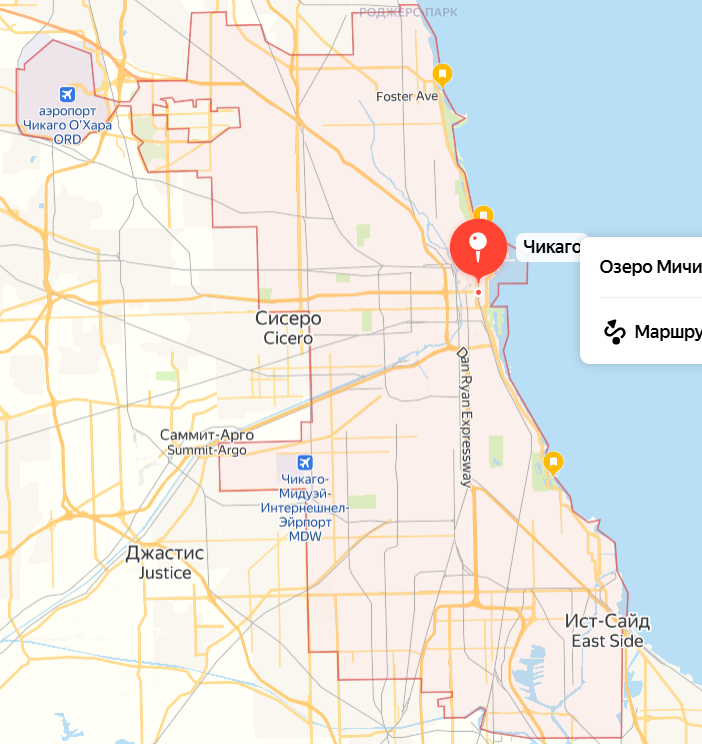

Можно заметить, что станции находяться близко к друг другу, поэтому даже если в одной из станции не было наблюдения, в другой станции будет похожее наблюдение. Поэтому можно удалять все записи с отсутствующими значениями.

In [39]:
weather = weather.dropna(how="any", axis=0).reset_index()
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115758 entries, 0 to 115757
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   index                  115758 non-null  int64         
 1   station_name           115758 non-null  object        
 2   measurement_timestamp  115758 non-null  datetime64[ns]
 3   air_temperature        115758 non-null  float64       
 4   humidity               115758 non-null  int64         
 5   rain_intensity         115758 non-null  float64       
 6   precipitation_type     115758 non-null  float64       
 7   wind_speed             115758 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 7.1+ MB


### 1.5 Проверим на явные дупликаты

In [40]:
duplicate_index = weather[weather.duplicated() == True]
duplicate_index

,index,station_name,measurement_timestamp,air_temperature,humidity,rain_intensity,precipitation_type,wind_speed


Их не оказалось

### 1.6 Переформотируем столбец `precipitation_type`

Значение в колонке `precipitation_type` числовое, что не очень удобно. Преобразуем `precipitation_type` в полезные ярлыки, используя описание с датасета: 
- Ясно, если `precipitation_type` находиться в промежутке между [0, 7]
- Дождь, если `precipitation_type` находиться в промежутке между [56, 63]
- Снег, если `precipitation_type` находиться в промежутке между [64, 70]

In [41]:
def formatting_precipitation_type(precipitation: int) -> str:
    if 0 <= precipitation <= 7:
        return "Ясно"
    if 56 <= precipitation <= 63:
        return "Дождь"
    if 64 <= precipitation <= 70:
        return "Снег"


weather["precipitation_type"] = weather["precipitation_type"].apply(formatting_precipitation_type)
weather["precipitation_type"].value_counts()

precipitation_type
Ясно     107611
Дождь      7268
Снег        879
Name: count, dtype: int64

### 1.7 Вывод

In [42]:
check_daily_coverage(weather)

Отчет о покрытии (интервалы 3 часов):
- Полностью покрытые дни: 96.1%
- Дни с отсутствующими интервалами: 128
- Даты без данных: 391
- Среднее количество интервалов/день: 7.9/8


После удаления, не особо сильно поменялось количество дней с отсутствующими интервалами и дат без данных. Значит оставляем эти изменения.

## 2. Добавление координат станции

In [43]:
sensor_locations = pd.read_csv(DATA_FOLDER / "Beach_Water_and_Weather_Sensor_Locations_20250409.csv")
sensor_locations.columns = sensor_locations.columns.str.lower().str.replace(" ", "_")
sensor_locations.head()

,sensor_name,sensor_type,latitude,longitude,location
0,Calumet Beach,Water,41.714739,-87.527356,"(41.714739, -87.527356)"
1,63rd Street Weather Station,Weather,41.780992,-87.572619,"(41.780992, -87.572619)"
2,63rd Street Beach,Water,41.784561,-87.571453,"(41.784561, -87.571453)"
3,Oak Street Weather Station,Weather,41.901997,-87.622817,"(41.901997, -87.622817)"
4,Foster Weather Station,Weather,41.976464,-87.647525,"(41.976464, -87.647525)"


In [44]:
total_weather = pd.merge(
    weather,
    sensor_locations,
    left_on="station_name",
    right_on="sensor_name",
    suffixes=(False, False),
)
total_weather.head(5)

,index,station_name,measurement_timestamp,air_temperature,humidity,rain_intensity,precipitation_type,wind_speed,sensor_name,sensor_type,latitude,longitude,location
0,0,63rd Street Weather Station,2018-09-27 10:00:00,16.4,61,0.0,Ясно,2.5,63rd Street Weather Station,Weather,41.780992,-87.572619,"(41.780992, -87.572619)"
1,1,63rd Street Weather Station,2018-09-27 11:00:00,17.1,51,0.0,Ясно,3.6,63rd Street Weather Station,Weather,41.780992,-87.572619,"(41.780992, -87.572619)"
2,2,63rd Street Weather Station,2018-09-27 13:00:00,18.2,51,0.0,Ясно,3.1,63rd Street Weather Station,Weather,41.780992,-87.572619,"(41.780992, -87.572619)"
3,4,63rd Street Weather Station,2018-09-27 15:00:00,19.5,47,0.0,Ясно,3.1,63rd Street Weather Station,Weather,41.780992,-87.572619,"(41.780992, -87.572619)"
4,6,63rd Street Weather Station,2018-09-27 16:00:00,20.2,38,0.0,Ясно,4.1,63rd Street Weather Station,Weather,41.780992,-87.572619,"(41.780992, -87.572619)"


Избавимся от ненужных колонок (`sensor_name`, `sensor_type`, `location`)

In [45]:
total_weather = total_weather[
    [
        "station_name",
        "measurement_timestamp",
        "air_temperature",
        "humidity",
        "rain_intensity",
        "precipitation_type",
        "wind_speed",
        "latitude",
        "longitude",
    ]
]
total_weather.head()

,station_name,measurement_timestamp,air_temperature,humidity,rain_intensity,precipitation_type,wind_speed,latitude,longitude
0,63rd Street Weather Station,2018-09-27 10:00:00,16.4,61,0.0,Ясно,2.5,41.780992,-87.572619
1,63rd Street Weather Station,2018-09-27 11:00:00,17.1,51,0.0,Ясно,3.6,41.780992,-87.572619
2,63rd Street Weather Station,2018-09-27 13:00:00,18.2,51,0.0,Ясно,3.1,41.780992,-87.572619
3,63rd Street Weather Station,2018-09-27 15:00:00,19.5,47,0.0,Ясно,3.1,41.780992,-87.572619
4,63rd Street Weather Station,2018-09-27 16:00:00,20.2,38,0.0,Ясно,4.1,41.780992,-87.572619


In [46]:
total_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115758 entries, 0 to 115757
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   station_name           115758 non-null  object        
 1   measurement_timestamp  115758 non-null  datetime64[ns]
 2   air_temperature        115758 non-null  float64       
 3   humidity               115758 non-null  int64         
 4   rain_intensity         115758 non-null  float64       
 5   precipitation_type     115758 non-null  object        
 6   wind_speed             115758 non-null  float64       
 7   latitude               115758 non-null  float64       
 8   longitude              115758 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 7.9+ MB


## 3. Обогащаем изначальные данные нашими сведениями

In [48]:
trips_stations1 = pd.read_parquet(TRIPS_FOLDER / "trips-stations_part_1.parquet")
trips_stations2 = pd.read_parquet(TRIPS_FOLDER / "trips-stations_part_2.parquet")
trips_stations3 = pd.read_parquet(TRIPS_FOLDER / "trips-stations_part_3.parquet")
trips_stations4 = pd.read_parquet(TRIPS_FOLDER / "trips-stations_part_4.parquet")
trips_stations5 = pd.read_parquet(TRIPS_FOLDER / "trips-stations_part_5.parquet")
trips_stations6 = pd.read_parquet(TRIPS_FOLDER / "trips-stations_part_6.parquet")
trips_stations7 = pd.read_parquet(TRIPS_FOLDER / "trips-stations_part_7.parquet")
trips_stations8 = pd.read_parquet(TRIPS_FOLDER / "trips-stations_part_8.parquet")
trips_stations9 = pd.read_parquet(TRIPS_FOLDER / "trips-stations_part_9.parquet")
trips_stations10 = pd.read_parquet(TRIPS_FOLDER / "trips-stations_part_10.parquet")

result_df = pd.concat(
    [
        trips_stations1,
        trips_stations2,
        trips_stations3,
        trips_stations4,
        trips_stations5,
        trips_stations6,
        trips_stations7,
        trips_stations8,
        trips_stations9,
        trips_stations10,
    ],
    ignore_index=True,
)

ArrowMemoryError: malloc of size 67108864 failed

In [ ]:
from scipy.spatial.distance import cdist


def find_closest_weather(ride_row, weather_df, max_time_diff=12):
    time_diff = abs(weather_df["measurement_timestamp"] - ride_row["started_at"])
    min_time_diff = time_diff.min()
    if min_time_diff > pd.Timedelta(hours=max_time_diff):
        return None

    closest_indices = time_diff[time_diff == min_time_diff].index
    if len(closest_indices) == 1:
        return closest_indices[0]

    ride_coords = np.array([[ride_row["start_lat"], ride_row["start_lng"]]])
    weather_coords = weather_df.loc[closest_indices, ["latitude", "longitude"]].values
    distances = cdist(ride_coords, weather_coords)[0]

    return closest_indices[np.argmin(distances)]

In [ ]:
weather_columns = [
    "weather_station_name",
    "weather_timestamp",
    "air_temperature",
    "humidity",
    "rain_intensity",
    "precipitation_type",
    "wind_speed",
]

for col in weather_columns:
    result_df[col] = pd.NA

In [ ]:
closest_weather_indices = [find_closest_weather(row, weather) for _, row in result_df.iterrows()]

for i, idx in enumerate(closest_weather_indices):
    if idx is not None:
        weather_row = weather.loc[idx]
        result_df.at[i, "weather_station_name"] = weather_row["station_name"]
        result_df.at[i, "weather_timestamp"] = weather_row["measurement_timestamp"]
        result_df.at[i, "air_temperature"] = weather_row["air_temperature"]
        result_df.at[i, "humidity"] = weather_row["humidity"]
        result_df.at[i, "rain_intensity"] = weather_row["rain_intensity"]
        result_df.at[i, "precipitation_type"] = weather_row["precipitation_type"]
        result_df.at[i, "wind_speed"] = weather_row["wind_speed"]

result_df.head()